# LeRobot Dataset Reward Visualization

This notebook allows you to visualize reward signals over time for LeRobot datasets. It can show rewards for individual episodes or all episodes in a dataset.

## Features
- Load any LeRobot dataset
- Visualize rewards for specific episodes
- Compare rewards across all episodes
- Identify reward patterns and interpolation effects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from pathlib import Path
import pandas as pd
from typing import Optional, List

# Import LeRobot dataset
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

# Set up plotting style
plt.style.use('default')
# sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Dataset Loading Function

In [2]:
def load_lerobot_dataset(repo_id: str, root: Optional[str] = None, episodes: Optional[List[int]] = None):
    """
    Load a LeRobot dataset.
    
    Args:
        repo_id: Dataset repository ID (e.g., 'lerobot/aloha_static_coffee')
        root: Local path to dataset (optional)
        episodes: List of episode indices to load (optional, loads all if None)
    
    Returns:
        LeRobotDataset object
    """
    try:
        dataset = LeRobotDataset(
            repo_id=repo_id,
            root=root,
            episodes=episodes,
            download_videos=False  # Don't download videos for reward analysis
        )
        print(f"✅ Successfully loaded dataset: {repo_id}")
        print(f"   - Total episodes: {dataset.num_episodes}")
        print(f"   - Total frames: {dataset.num_frames}")
        print(f"   - FPS: {dataset.fps}")
        
        # Check if reward feature exists
        if "reward" in dataset.features:
            print(f"   - Reward feature: ✅ Available")
        else:
            print(f"   - Reward feature: ❌ Not available")
            
        return dataset
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return None

## Reward Analysis Functions

In [3]:
def extract_episode_rewards(dataset: LeRobotDataset, episode_idx: int) -> dict:
    """
    Extract reward data for a specific episode.
    
    Args:
        dataset: LeRobot dataset
        episode_idx: Episode index
    
    Returns:
        Dictionary with reward data
    """
    # Filter dataset for the specific episode
    episode_data = dataset.hf_dataset.filter(lambda x: x["episode_index"] == episode_idx)
    
    if len(episode_data) == 0:
        return None
    
    # Extract reward and timing information
    rewards = episode_data["reward"]
    frame_indices = episode_data["frame_index"]
    timestamps = episode_data["timestamp"]
    
    # Convert to numpy arrays
    rewards = np.array([r.item() if hasattr(r, 'item') else r for r in rewards])
    frame_indices = np.array([f.item() if hasattr(f, 'item') else f for f in frame_indices])
    timestamps = np.array([t.item() if hasattr(t, 'item') else t for t in timestamps])
    
    return {
        'rewards': rewards,
        'frame_indices': frame_indices,
        'timestamps': timestamps,
        'episode_length': len(rewards),
        'duration': timestamps[-1] - timestamps[0] if len(timestamps) > 1 else 0,
        'max_reward': np.max(rewards),
        'min_reward': np.min(rewards),
        'mean_reward': np.mean(rewards),
        'total_reward': np.sum(rewards)
    }

def analyze_reward_pattern(rewards: np.ndarray) -> dict:
    """
    Analyze the pattern of rewards in an episode.
    
    Args:
        rewards: Array of reward values
    
    Returns:
        Dictionary with analysis results
    """
    # Find non-zero rewards (keyframes)
    keyframe_indices = np.where(rewards > 0)[0]
    keyframe_values = rewards[keyframe_indices]
    
    # Calculate reward changes
    reward_changes = np.diff(rewards)
    positive_changes = np.sum(reward_changes > 0)
    negative_changes = np.sum(reward_changes < 0)
    
    # Detect if rewards are interpolated (smooth transitions)
    is_interpolated = len(keyframe_indices) > 0 and len(keyframe_indices) < len(rewards)
    
    return {
        'num_keyframes': len(keyframe_indices),
        'keyframe_indices': keyframe_indices,
        'keyframe_values': keyframe_values,
        'is_interpolated': is_interpolated,
        'positive_changes': positive_changes,
        'negative_changes': negative_changes,
        'reward_variance': np.var(rewards),
        'reward_std': np.std(rewards)
    }

## Visualization Functions

In [4]:
def plot_single_episode_rewards(dataset: LeRobotDataset, episode_idx: int, 
                               show_analysis: bool = True, 
                               save_path: Optional[str] = None):
    """
    Plot rewards for a single episode.
    
    Args:
        dataset: LeRobot dataset
        episode_idx: Episode index to plot
        show_analysis: Whether to show analysis information
        save_path: Path to save the plot (optional)
    """
    # Extract episode data
    episode_data = extract_episode_rewards(dataset, episode_idx)
    
    if episode_data is None:
        print(f"❌ Episode {episode_idx} not found in dataset")
        return
    
    # Analyze reward pattern
    analysis = analyze_reward_pattern(episode_data['rewards'])
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Rewards over time
    ax1.plot(episode_data['timestamps'], episode_data['rewards'], 
             linewidth=2, color='blue', alpha=0.8, label='Reward')
    
    # Highlight keyframes if interpolated
    # if analysis['is_interpolated']:
    #     keyframe_times = episode_data['timestamps'][analysis['keyframe_indices']]
    #     keyframe_rewards = analysis['keyframe_values']
    #     ax1.scatter(keyframe_times, keyframe_rewards, 
    #                color='red', s=100, zorder=5, label='Keyframes')
    
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'Reward Signal - Episode {episode_idx}')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    plt.tight_layout()
    
    # Show analysis if requested
    if show_analysis:
        print(f"\n📊 Episode {episode_idx} Analysis:")
        print(f"   Duration: {episode_data['duration']:.2f} seconds")
        print(f"   Frames: {episode_data['episode_length']}")
        print(f"   Max reward: {episode_data['max_reward']:.3f}")
        print(f"   Min reward: {episode_data['min_reward']:.3f}")
        print(f"   Mean reward: {episode_data['mean_reward']:.3f}")
        print(f"   Total reward: {episode_data['total_reward']:.3f}")
        print(f"   Keyframes: {analysis['num_keyframes']}")
        print(f"   Interpolated: {'Yes' if analysis['is_interpolated'] else 'No'}")
        
        if analysis['num_keyframes'] > 0:
            print(f"   Keyframe values: {[f'{v:.3f}' for v in analysis['keyframe_values']]}")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Plot saved to: {save_path}")
    
    plt.show()

def plot_all_episodes_rewards(dataset: LeRobotDataset, 
                             max_episodes: int = 20, 
                             save_path: Optional[str] = None):
    """
    Plot rewards for all episodes in a dataset.
    
    Args:
        dataset: LeRobot dataset
        max_episodes: Maximum number of episodes to plot (for performance)
        save_path: Path to save the plot (optional)
    """
    num_episodes = min(dataset.num_episodes, max_episodes)
    
    # Create subplots
    fig, axes = plt.subplots(num_episodes, 1, figsize=(14, 3 * num_episodes))
    if num_episodes == 1:
        axes = [axes]
    
    episode_stats = []
    
    for i in range(num_episodes):
        episode_data = extract_episode_rewards(dataset, i)
        
        if episode_data is None:
            continue
        
        # Plot rewards
        axes[i].plot(episode_data['timestamps'], episode_data['rewards'], 
                    linewidth=1.5, alpha=0.8)
        
        # Highlight keyframes
        analysis = analyze_reward_pattern(episode_data['rewards'])
        if analysis['is_interpolated']:
            keyframe_times = episode_data['timestamps'][analysis['keyframe_indices']]
            keyframe_rewards = analysis['keyframe_values']
            axes[i].scatter(keyframe_times, keyframe_rewards, 
                          color='red', s=50, zorder=5)
        
        axes[i].set_title(f'Episode {i} (Max: {episode_data["max_reward"]:.3f}, Total: {episode_data["total_reward"]:.3f})')
        axes[i].grid(True, alpha=0.3)
        
        # Store stats
        episode_stats.append({
            'episode': i,
            'max_reward': episode_data['max_reward'],
            'total_reward': episode_data['total_reward'],
            'duration': episode_data['duration'],
            'num_keyframes': analysis['num_keyframes'],
            'is_interpolated': analysis['is_interpolated']
        })
    
    # Add common labels
    fig.text(0.5, 0.02, 'Time (seconds)', ha='center', va='center', fontsize=14)
    fig.text(0.02, 0.5, 'Reward', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout()
    
    # Print summary statistics
    print(f"\n📊 Dataset Summary ({num_episodes} episodes):")
    df_stats = pd.DataFrame(episode_stats)
    print(f"   Average max reward: {df_stats['max_reward'].mean():.3f}")
    print(f"   Average total reward: {df_stats['total_reward'].mean():.3f}")
    print(f"   Average duration: {df_stats['duration'].mean():.2f} seconds")
    print(f"   Episodes with interpolation: {df_stats['is_interpolated'].sum()}/{num_episodes}")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Plot saved to: {save_path}")
    
    plt.show()
    
    return df_stats

def plot_reward_comparison(dataset: LeRobotDataset, episode_indices: List[int], 
                          save_path: Optional[str] = None):
    """
    Compare rewards across multiple episodes.
    
    Args:
        dataset: LeRobot dataset
        episode_indices: List of episode indices to compare
        save_path: Path to save the plot (optional)
    """
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(episode_indices)))
    
    for i, episode_idx in enumerate(episode_indices):
        episode_data = extract_episode_rewards(dataset, episode_idx)
        
        if episode_data is None:
            continue
        
        # Normalize time to 0-1 for comparison
        normalized_time = (episode_data['timestamps'] - episode_data['timestamps'][0]) / episode_data['duration']
        
        ax.plot(normalized_time, episode_data['rewards'], 
               linewidth=2, alpha=0.8, color=colors[i], 
               label=f'Episode {episode_idx}')
    
    ax.set_xlabel('Normalized Time (0-1)')
    ax.set_ylabel('Reward')
    ax.set_title('Reward Comparison Across Episodes')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Plot saved to: {save_path}")
    
    plt.show()

## Usage Examples

### 1. Load a Dataset

In [49]:
# Example: Load a dataset (replace with your dataset ID)
repo_id = "villekuosmanen/fail_drop_footbag_into_dice_tower"  # Replace with your dataset
# repo_id = "your_username/your_dataset"

dataset = load_lerobot_dataset(repo_id)

if dataset is None:
    print("Please provide a valid dataset ID or check your internet connection.")
    print("\nExample dataset IDs:")
    print("  - lerobot/aloha_static_coffee")
    print("  - lerobot/aloha_static_peel_banana")
    print("  - lerobot/aloha_static_insert_peg")
    print("\nOr use a local dataset by providing the root path:")
    print("  dataset = load_lerobot_dataset('my_dataset', root='/path/to/dataset')")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

episodes_stats.jsonl: 0.00B [00:00, ?B/s]

tasks.jsonl:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

info.json: 0.00B [00:00, ?B/s]

episodes.jsonl: 0.00B [00:00, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

episode_000001.parquet:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

episode_000005.parquet:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

episode_000002.parquet:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

episode_000004.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

episode_000003.parquet:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

episode_000000.parquet:   0%|          | 0.00/18.9k [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

episode_000007.parquet:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

episode_000008.parquet:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

episode_000011.parquet:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

episode_000013.parquet:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

episode_000009.parquet:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

episode_000010.parquet:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

episode_000012.parquet:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

episode_000006.parquet:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

episode_000014.parquet:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

episode_000015.parquet:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

episode_000016.parquet:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

episode_000017.parquet:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

episode_000018.parquet:   0%|          | 0.00/42.5k [00:00<?, ?B/s]

episode_000019.parquet:   0%|          | 0.00/41.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

✅ Successfully loaded dataset: villekuosmanen/fail_drop_footbag_into_dice_tower
   - Total episodes: 20
   - Total frames: 3049
   - FPS: 20
   - Reward feature: ✅ Available


### 2. Visualize a Single Episode

Filter:   0%|          | 0/3049 [00:00<?, ? examples/s]


📊 Episode 2 Analysis:
   Duration: 6.20 seconds
   Frames: 125
   Max reward: 0.250
   Min reward: 0.000
   Mean reward: 0.069
   Total reward: 8.610
   Keyframes: 124
   Interpolated: Yes
   Keyframe values: ['0.000', '0.002', '0.004', '0.007', '0.011', '0.016', '0.021', '0.027', '0.034', '0.041', '0.048', '0.056', '0.065', '0.074', '0.082', '0.092', '0.101', '0.111', '0.120', '0.130', '0.139', '0.149', '0.158', '0.168', '0.176', '0.185', '0.194', '0.202', '0.209', '0.216', '0.223', '0.229', '0.234', '0.239', '0.243', '0.246', '0.248', '0.250', '0.250', '0.249', '0.245', '0.240', '0.232', '0.223', '0.213', '0.201', '0.188', '0.174', '0.160', '0.145', '0.130', '0.115', '0.100', '0.086', '0.072', '0.059', '0.047', '0.037', '0.028', '0.020', '0.015', '0.011', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010', '0.010

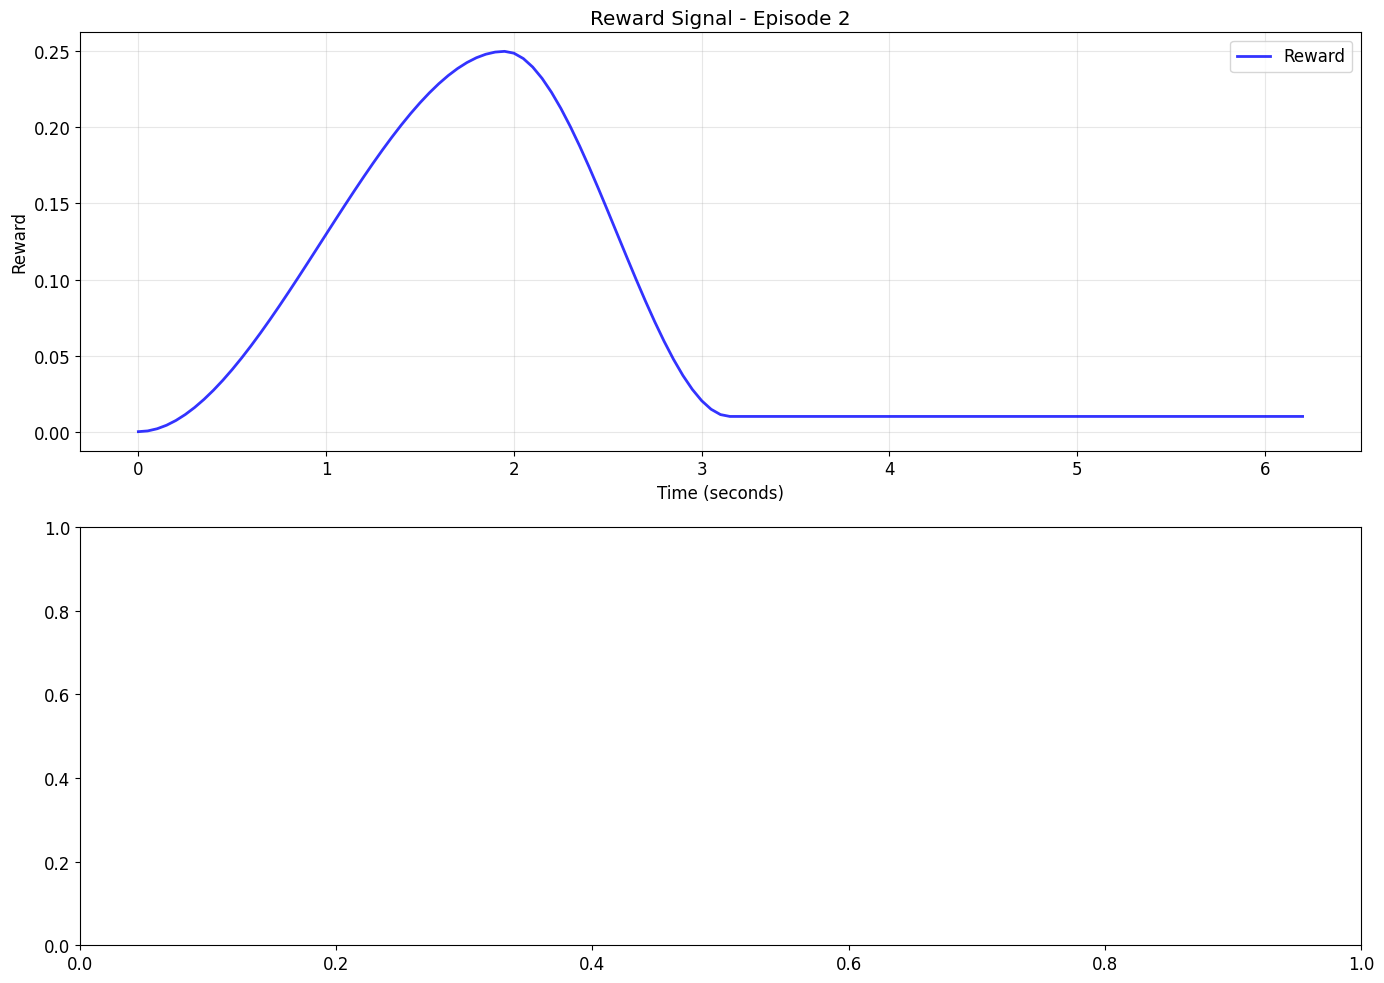

In [56]:
# Visualize rewards for episode 0 (change the episode number as needed)
if dataset is not None:
    plot_single_episode_rewards(dataset, episode_idx=2)

### 3. Visualize All Episodes

Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1245 [00:00<?, ? examples/s]


📊 Dataset Summary (20 episodes):
   Average max reward: 0.113
   Average total reward: 4.069
   Average duration: 3.06 seconds
   Episodes with interpolation: 9/20


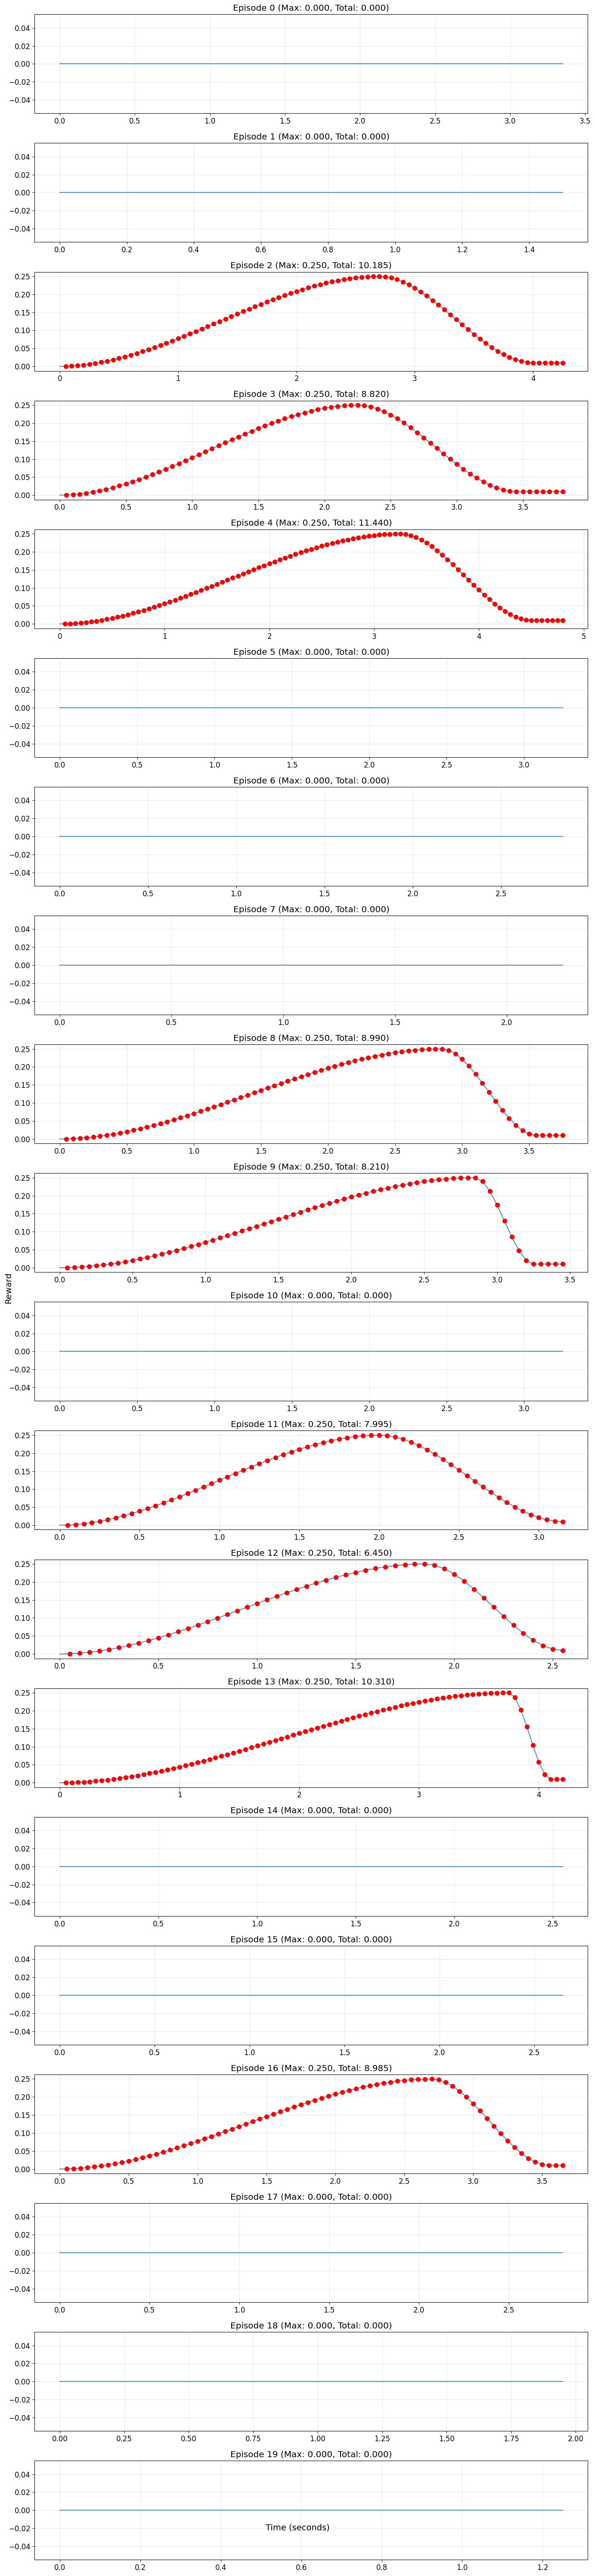

In [43]:
# Visualize rewards for all episodes (limited to first 10 for performance)
if dataset is not None:
    stats = plot_all_episodes_rewards(dataset, max_episodes=30)

### 4. Compare Specific Episodes

Filter:   0%|          | 0/7420 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7420 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7420 [00:00<?, ? examples/s]

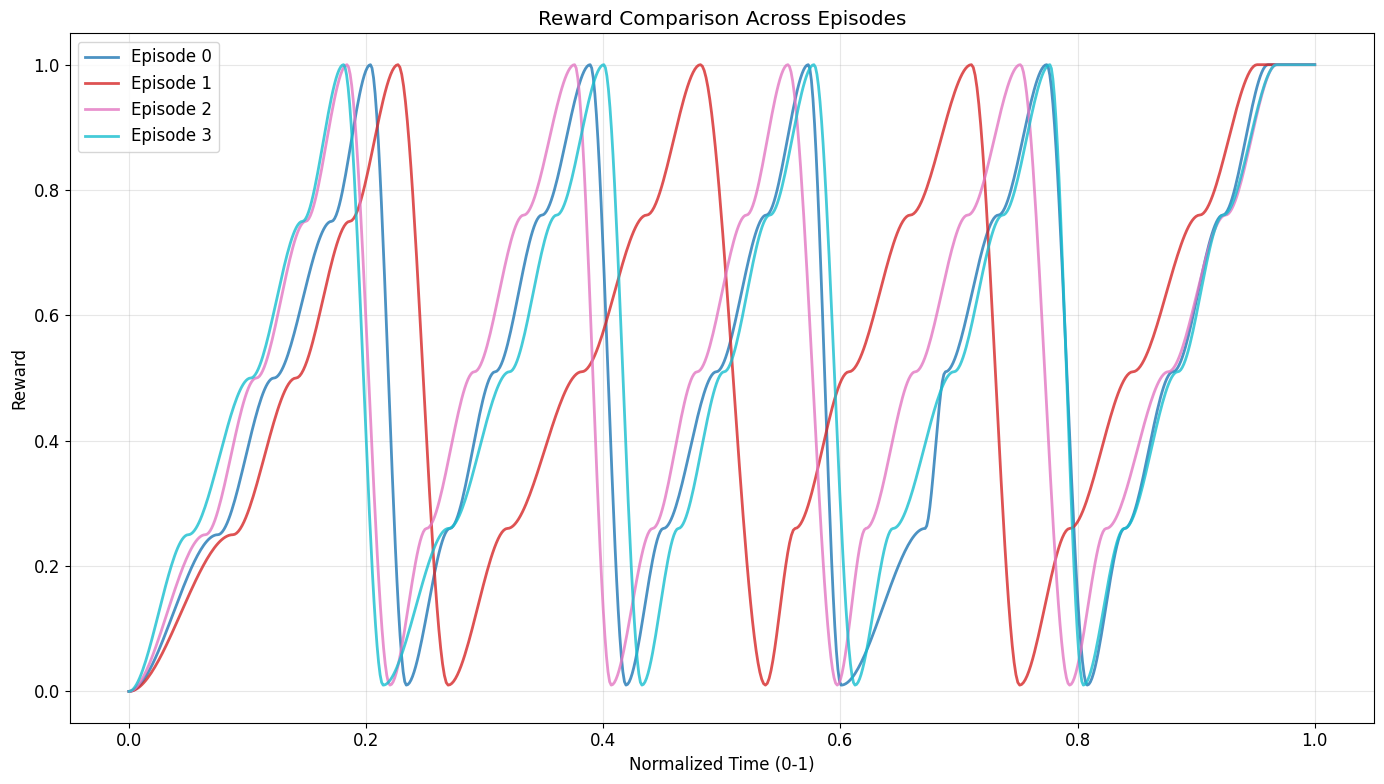

In [14]:
# Compare rewards across specific episodes
if dataset is not None:
    plot_reward_comparison(dataset, episode_indices=[0, 1, 2, 3])

### 5. Interactive Episode Selection

In [ ]:
# Interactive function to explore different episodes
def explore_episodes(dataset: LeRobotDataset):
    """Interactive function to explore episodes."""
    if dataset is None:
        print("No dataset loaded.")
        return
    
    print(f"Dataset has {dataset.num_episodes} episodes.")
    
    while True:
        try:
            episode_idx = input(f"\nEnter episode number (0-{dataset.num_episodes-1}) or 'q' to quit: ")
            
            if episode_idx.lower() == 'q':
                break
            
            episode_idx = int(episode_idx)
            
            if 0 <= episode_idx < dataset.num_episodes:
                plot_single_episode_rewards(dataset, episode_idx)
            else:
                print(f"Invalid episode number. Please enter a number between 0 and {dataset.num_episodes-1}.")
                
        except ValueError:
            print("Please enter a valid number or 'q' to quit.")
        except KeyboardInterrupt:
            print("\nExiting...")
            break

# Uncomment to use interactive exploration
# explore_episodes(dataset)

### 6. Save Plots

In [ ]:
# Example: Save plots to files
if dataset is not None:
    # Save single episode plot
    plot_single_episode_rewards(dataset, episode_idx=0, 
                               save_path="episode_0_rewards.png")
    
    # Save all episodes plot
    plot_all_episodes_rewards(dataset, max_episodes=5, 
                             save_path="all_episodes_rewards.png")
    
    # Save comparison plot
    plot_reward_comparison(dataset, episode_indices=[0, 1, 2], 
                          save_path="episode_comparison.png")

## Advanced Analysis

In [ ]:
def analyze_dataset_rewards(dataset: LeRobotDataset):
    """Perform comprehensive analysis of rewards across the dataset."""
    if dataset is None:
        return
    
    all_stats = []
    
    for episode_idx in range(dataset.num_episodes):
        episode_data = extract_episode_rewards(dataset, episode_idx)
        if episode_data is not None:
            analysis = analyze_reward_pattern(episode_data['rewards'])
            
            all_stats.append({
                'episode': episode_idx,
                'max_reward': episode_data['max_reward'],
                'total_reward': episode_data['total_reward'],
                'mean_reward': episode_data['mean_reward'],
                'duration': episode_data['duration'],
                'num_frames': episode_data['episode_length'],
                'num_keyframes': analysis['num_keyframes'],
                'is_interpolated': analysis['is_interpolated'],
                'reward_variance': analysis['reward_variance'],
                'reward_std': analysis['reward_std']
            })
    
    df = pd.DataFrame(all_stats)
    
    print("\n📊 Comprehensive Dataset Analysis:")
    print("=" * 50)
    
    print(f"\n📈 Reward Statistics:")
    print(f"   Average max reward: {df['max_reward'].mean():.3f} ± {df['max_reward'].std():.3f}")
    print(f"   Average total reward: {df['total_reward'].mean():.3f} ± {df['total_reward'].std():.3f}")
    print(f"   Average mean reward: {df['mean_reward'].mean():.3f} ± {df['mean_reward'].std():.3f}")
    
    print(f"\n⏱️  Duration Statistics:")
    print(f"   Average duration: {df['duration'].mean():.2f} ± {df['duration'].std():.2f} seconds")
    print(f"   Average frames: {df['num_frames'].mean():.1f} ± {df['num_frames'].std():.1f}")
    
    print(f"\n🎯 Interpolation Analysis:")
    interpolated_count = df['is_interpolated'].sum()
    print(f"   Episodes with interpolation: {interpolated_count}/{len(df)} ({interpolated_count/len(df)*100:.1f}%)")
    print(f"   Average keyframes per episode: {df['num_keyframes'].mean():.1f} ± {df['num_keyframes'].std():.1f}")
    
    print(f"\n📊 Reward Variability:")
    print(f"   Average reward variance: {df['reward_variance'].mean():.3f} ± {df['reward_variance'].std():.3f}")
    print(f"   Average reward std: {df['reward_std'].mean():.3f} ± {df['reward_std'].std():.3f}")
    
    # Create summary plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Max rewards distribution
    axes[0, 0].hist(df['max_reward'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Max Reward')
    axes[0, 0].set_ylabel('Number of Episodes')
    axes[0, 0].set_title('Distribution of Max Rewards')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Total rewards distribution
    axes[0, 1].hist(df['total_reward'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_xlabel('Total Reward')
    axes[0, 1].set_ylabel('Number of Episodes')
    axes[0, 1].set_title('Distribution of Total Rewards')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Duration vs Total Reward
    axes[1, 0].scatter(df['duration'], df['total_reward'], alpha=0.6, color='orange')
    axes[1, 0].set_xlabel('Duration (seconds)')
    axes[1, 0].set_ylabel('Total Reward')
    axes[1, 0].set_title('Duration vs Total Reward')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Keyframes vs Total Reward
    axes[1, 1].scatter(df['num_keyframes'], df['total_reward'], alpha=0.6, color='purple')
    axes[1, 1].set_xlabel('Number of Keyframes')
    axes[1, 1].set_ylabel('Total Reward')
    axes[1, 1].set_title('Keyframes vs Total Reward')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df

# Run comprehensive analysis
if dataset is not None:
    analysis_df = analyze_dataset_rewards(dataset)

## Tips for Analysis

1. **Interpolation Detection**: Red dots on the plots indicate keyframes where rewards were manually set during recording.
2. **Smooth vs Linear**: Look for the smoothness of transitions between keyframes to identify the interpolation method used.
3. **Reward Patterns**: Analyze how rewards progress throughout episodes to understand task completion patterns.
4. **Episode Comparison**: Compare episodes to identify consistent vs variable reward patterns.
5. **Performance Metrics**: Use the comprehensive analysis to understand dataset quality and reward distribution.

## Troubleshooting

- **No reward feature**: If the dataset doesn't have a reward feature, the plots will show empty or zero rewards.
- **Large datasets**: For very large datasets, limit the number of episodes plotted to avoid performance issues.
- **Local datasets**: Use the `root` parameter to load datasets stored locally.
- **Memory issues**: For very long episodes, consider loading only specific episodes using the `episodes` parameter.